In [1]:
import os
import torch
import torch.nn as nn
import torch_geometric as pyg
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import load_pickle
from model.models_unet import GraphFloorplanUNet
import cv2
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

ModuleNotFoundError: No module named 'models'

In [4]:
def visualize_result(boundary_image_np, gt_image_np, predicted_np):
    colors = ['#1f77b4','#e6550d','#fd8d3c','#87ceeb','#ffff00','#72246c','#5254a3','#6b6ecf','#2ca02c','#000000','white']
    cmap = ListedColormap(colors)
    
    # Plot the boundary image, prediction, and ground truth
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(boundary_image_np, cmap='gray')
    # axs[0].set_title('Boundary Image')
    axs[0].axis('off')

    predicted_np[predicted_np == 13] = 10
    axs[1].imshow(predicted_np, cmap=cmap)
    # axs[1].set_title('Prediction')
    axs[1].axis('off')

    gt_image_np[gt_image_np == 13] = 10
    im = axs[2].imshow(gt_image_np, cmap=cmap)
    # axs[2].set_title('Ground Truth')
    axs[2].axis('off')

    # Create legend
    legend_labels = {
        'Bedroom': 0,
        'Livingroom': 1,
        'Kitchen': 2,
        'Dining': 3, 
        'Corridor': 4,
        'Stairs': 5,
        'Storeroom': 6,
        'Bathroom': 7,
        'Balcony': 8,
        'Structure': 9,
        'Background': 10  # Adjusted the value to match the colors list index
    }
    legend_handles = [Patch(color=colors[value], label=label) for label, value in legend_labels.items()]
    plt.legend(handles=legend_handles, bbox_to_anchor=(-1, 0.0), loc='upper center', ncol=6, fontsize=14)

    plt.tight_layout()
    plt.show()


def infer(model, boundary_image, graph_pyg):
    model.eval()

    with torch.no_grad():
        # Perform inference
        output = model(boundary_image.unsqueeze(0).cuda(), graph_pyg.to('cuda'))
        predicted = torch.argmax(output, dim=1)

        # Convert tensors to numpy arrays
        predicted_np = predicted.cpu().numpy()[0]

    return predicted_np


def load_sample(graph_path, struct_path):
    transform = transforms.ToTensor()

    # Load struct image
    struct_in = np.load(struct_path)
    boundary_image = struct_in.astype(np.uint8) 
    boundary_image = transform(boundary_image)

    # Load graph
    num_room_types = 4  
    num_connection_types = 3 
    connection_dic = {'door': 0, 'entrance': 1, 'passage': 2}
    
    graph_nx = load_pickle(graph_path)
    graph_nx.graph['struct'] = struct_in[np.newaxis, ...]
    node_features = []
    for _, node_data in graph_nx.nodes(data=True):
        node_type = node_data['zoning_type']
        node_feature = [0]*num_room_types
        node_feature[node_type] = 1
        node_features.append(node_feature)
    
    # Add node features if not present
    edge_features = []
    for _, _, edge_data in graph_nx.edges(data=True):
        connection_type = connection_dic[edge_data['connectivity']]
        edge_feature = [0]*num_connection_types
        edge_feature[connection_type] = 1
        edge_features.append(edge_feature)

    # Convert to PyG graph
    graph_pyg = pyg.utils.from_networkx(graph_nx)
    graph_pyg.x = torch.tensor(node_features, dtype=torch.float)  # node features
    graph_pyg.edge_attr = torch.tensor(edge_features, dtype=torch.float)  # edge features
    
    return boundary_image, graph_pyg


In [7]:
# Create the model
num_node_features = 4
input_nc = 3
output_nc = 11

model = GraphFloorplanUNet(num_node_features, input_nc, output_nc, features=[64, 128, 256, 512]).cuda()

model.load_state_dict(torch.load('./checkpoints/model_checkpoint_epoch_99.pt'))


<All keys matched successfully>

In [19]:
id = 1773

In [20]:
# Load sample
graph_path = '../processed_dataset/test/graph_in/'+str(id)+'.pickle'
struct_path = '../processed_dataset/test/struct_in/'+str(id)+'.npy'
boundary_image, graph_pyg = load_sample(graph_path, struct_path)


boundary_image = boundary_image.cuda()
graph_pyg = graph_pyg.cuda()

/tmp/ipykernel_58077/408546114.py:39: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


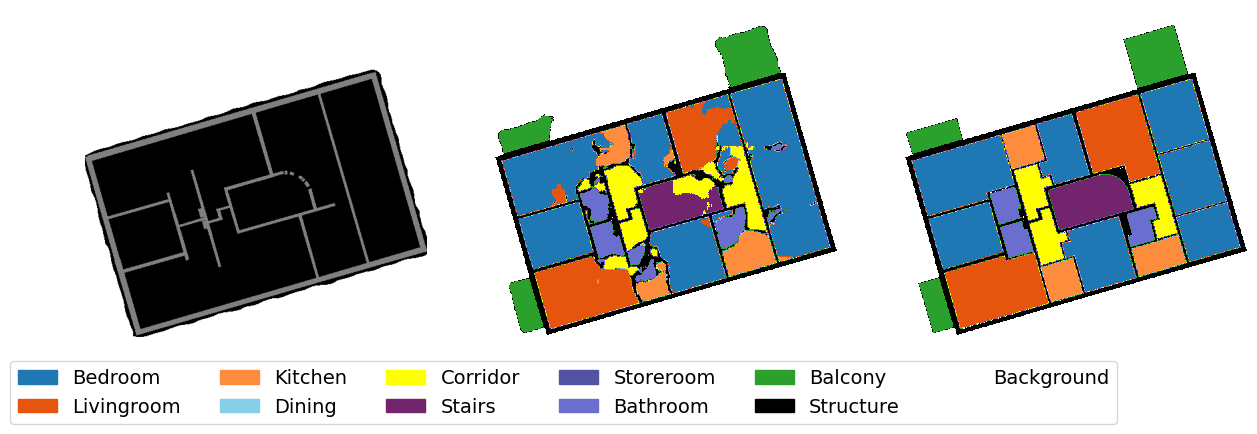

In [21]:
# Perform inference
predicted = infer(model, boundary_image, graph_pyg)

# Load ground truth image
full_path = '../processed_dataset/test/full_out/'+str(id)+'.npy'
gt_image_np = np.load(full_path)[..., 0]

raw_boundary_image_path = '../processed_dataset/test/struct_in/'+str(id)+'.npy'
boundary_image_np = np.load(raw_boundary_image_path)
boundary_img = boundary_image_np[..., 0].astype(np.uint8)

# Visualize the result
visualize_result(boundary_img, gt_image_np, predicted)